### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [2]:
mth = rets.index[0]
start_mth = mth + pd.DateOffset(months=1)
start_mth

Timestamp('2000-08-01 00:00:00')

In [3]:
#rank transform wrds
dfs = []
for name, df_group in wrds_svm.groupby(['MonthStart']):
    ranked_df = df_group.loc[:,'srcq':'Vol'].rank(axis = 0)/(len(df_group)+1)
    standardized_df = (ranked_df - ranked_df.mean(axis = 0))/ranked_df.std(axis = 0)
    standardized_df.drop(columns= ['DIFFYear', 'date', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays', 'DIFFExpectedDaysCorr'], inplace = True)
    dfs.append(standardized_df)
wrds_standard = pd.concat(dfs, axis = 0, ignore_index= False)

In [4]:
#groupby then rank within groups
flattened_returns = rets.melt(ignore_index=False, var_name='tic').reset_index()
flattened_returns = flattened_returns.rename(columns ={'StartMonth': 'MonthStart'})
flattened_returns.index = pd.MultiIndex.from_frame(flattened_returns[['MonthStart', 'tic']])
flattened_returns.drop(columns = ['MonthStart', 'tic'], inplace=True)
dataset = pd.merge(flattened_returns, wrds_standard, left_index=True, right_index=True, how = 'inner')
dataset.sort_index(inplace=True)

In [5]:
dataset.corr()

,value,srcq,actq,ancq,atq,ceqq,cheq,cogsq,cshiq,cshopq,...,GRW1,GRW2,GRW3,GRW4,GRW5,GRW6,GRW7,GRW8,Momentum,Vol
value,1.000000,-0.002320,-0.031722,-0.035924,-0.036028,-0.041059,-0.020126,-0.024310,-0.032824,-0.013320,...,0.009347,-0.008847,-0.009698,-0.023696,-0.011419,-0.005148,0.016001,0.012593,-0.021517,0.022696
srcq,-0.002320,1.000000,0.056828,0.080772,0.075569,0.070933,0.056719,0.037680,0.075299,0.021901,...,0.037361,0.000232,0.034685,0.011772,0.013603,0.021685,0.026219,0.007749,-0.018573,0.031917
actq,-0.031722,0.056828,1.000000,0.700802,0.826355,0.759614,0.781132,0.786579,0.767696,0.376503,...,0.013261,0.030783,0.028106,0.014676,-0.009351,0.044841,-0.020672,0.003967,-0.103775,-0.160635
ancq,-0.035924,0.080772,0.700802,1.000000,0.969002,0.866302,0.469460,0.717686,0.716956,0.258812,...,0.078147,0.041049,0.065925,0.015890,0.019824,0.075665,-0.006072,0.028346,-0.119961,-0.309721
atq,-0.036028,0.075569,0.826355,0.969002,1.000000,0.895022,0.587821,0.780258,0.775325,0.298532,...,0.058231,0.037140,0.059191,0.015105,0.017102,0.070930,-0.009082,0.022537,-0.119384,-0.287779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GRW6,-0.005148,0.021685,0.044841,0.075665,0.070930,0.037148,0.015067,0.049276,0.075500,0.205075,...,0.354095,0.148916,0.448785,0.163213,0.079588,1.000000,0.055920,0.117537,-0.097413,-0.038057
GRW7,0.016001,0.026219,-0.020672,-0.006072,-0.009082,-0.003323,-0.010048,-0.017808,-0.002057,0.003050,...,0.080999,0.145931,0.042491,0.028968,0.432330,0.055920,1.000000,0.054078,-0.001820,0.030230
GRW8,0.012593,0.007749,0.003967,0.028346,0.022537,0.010052,0.011916,0.012847,0.019907,0.016414,...,0.355792,0.452678,0.129350,0.217957,-0.051855,0.117537,0.054078,1.000000,-0.045908,-0.009205
Momentum,-0.021517,-0.018573,-0.103775,-0.119961,-0.119384,-0.125021,-0.056158,-0.091489,-0.114559,-0.069437,...,-0.076031,-0.080981,-0.089224,-0.067415,-0.021332,-0.097413,-0.001820,-0.045908,1.000000,0.095089


# SK LEARN Implementation

The best parameters are {'C': 3125.0, 'gamma': 0.05719876593234916} with a score of 0.57


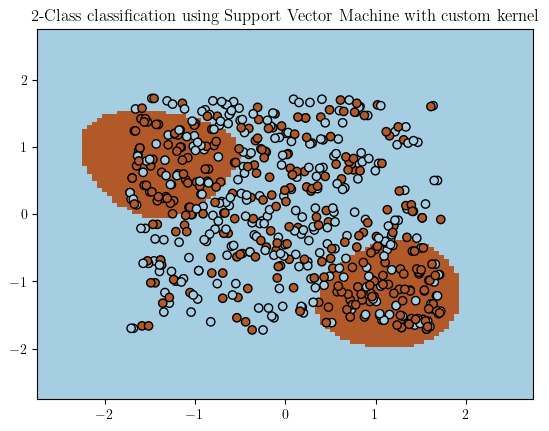

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
idx = pd.IndexSlice

X = dataset.loc[idx[:start_mth,:], ['Vol', 'ceqq']].values #'srcq':'Vol'].values
y = dataset.loc[idx[:start_mth,:], 'value'].values
y = (y  >= np.percentile(y, 50)).astype(int)
X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)
# clf = svm.SVC(kernel='precomputed')
# gram_train = rbf_gram(X_train, X_train, sigma = 0.1)
# clf.fit(gram_train, y_train)
# gram_test = rbf_gram(X_test, X_train, sigma = 0.1)
# clf.predict(gram_test)

# clf = svm.SVC(kernel='rbf')
# clf.fit(X, y)

C_range = np.logspace(-1, 5, 10, base = 5)
gamma_range = np.logspace(-4, 1, 10, base=5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(class_weight={1: 1}), param_grid=param_grid, cv=cv, scoring = 'accuracy')
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    grid,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
plt.title("2-Class classification using Support Vector Machine with custom kernel")
plt.axis("tight")
plt.show()

# Custom Implementation

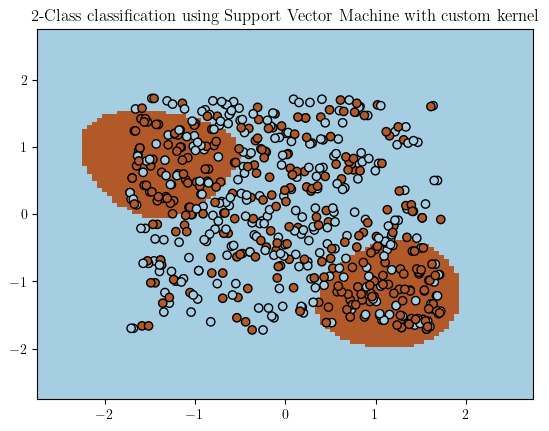

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

def rbf_gram(X, Y, gamma):
    dists_sq = get_pairwise_distances(X, Y)
    # turn into an RBF gram matrix
    km = dists_sq; del dists_sq
    km *= -1 * gamma
    np.exp(km, km)  # exponentiates in-place
    return km

def get_pairwise_distances(X, Y):
    """

    :param X:
    :return:
    """
    # get a matrix where the (i, j)th element is |x[i] - x[j]|^2
# using the identity (x - y)^T (x - y) = x^T x + y^T y - 2 x^T y
    n, p = X.shape
    pt_sq_norms_x = (X ** 2).sum(axis=1)
    pt_sq_norms_y = (Y ** 2).sum(axis=1)
    dists_sq = np.dot(X, Y.T) #n by m
    dists_sq *= -2
    dists_sq += pt_sq_norms_x.reshape(-1, 1)
    dists_sq += pt_sq_norms_y
    #dists_sq = dists_sq/(p**2)
    return dists_sq

# Wrapper class for the custom kernel chi2_kernel
class CustomRBFKernel(BaseEstimator,TransformerMixin):
    def __init__(self, gamma=1.0):
        super(CustomRBFKernel,self).__init__()
        self.gamma = gamma

    def transform(self, X):
        return rbf_gram(X, self.X_train_, gamma=self.gamma)

    def fit(self, X, y=None, **fit_params):
        self.X_train_ = X
        return self


def train_svm(X, y, gamma_range, C_range, plot = False):
    # Create a pipeline where our custom predefined kernel Chi2Kernel
    # is run before SVC.
    pipe = Pipeline([
        ('sbf', CustomRBFKernel()),
        ('svm', SVC()),
    ])

    # Set the parameter 'gamma' of our custom kernel by
    # using the 'estimator__param' syntax.

    cv_params = dict([
        ('sbf__gamma', gamma_range),
        ('svm__kernel', ['precomputed']),
        ('svm__C', C_range),
    ])

    # Do grid search to get the best parameter value of 'gamma'.
    grid = GridSearchCV(pipe, cv_params, cv=cv, scoring = 'accuracy')
    grid.fit(X, y)

    if plot:
        ax = plt.gca()
        DecisionBoundaryDisplay.from_estimator(
            grid,
            X,
            cmap=plt.cm.Paired,
            ax=ax,
            response_method="predict",
            plot_method="pcolormesh",
            shading="auto",
        )

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
        plt.title("2-Class classification using Support Vector Machine with custom kernel")
        plt.axis("tight")
        plt.show()

        return grid